In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import torch
import torch.nn as nn
import torch.nn.functional as F

In [2]:
def generate_vortex_flow(size=224, strength=1.0, center=None):
    """Generate a vortex (rotational) flow field"""
    if center is None:
        center = (size//2, size//2)
    
    y, x = np.mgrid[:size, :size]
    x = x - center[0]
    y = y - center[1]
    
    # Distance from center (add small epsilon to avoid division by zero)
    r = np.sqrt(x**2 + y**2) + 1e-6
    
    # Normalize by the size to control the strength
    r_norm = r / size
    
    # Compute tangential components (counter-clockwise vortex)
    u = -strength * y / r_norm
    v = strength * x / r_norm
    
    # Normalize the flow to have consistent magnitude
    magnitude = np.sqrt(u**2 + v**2)
    max_mag = np.max(magnitude)
    u = u / max_mag
    v = v / max_mag
    
    return np.stack([u, v], axis=-1)

def generate_sink_flow(size=224, strength=1.0, center=None):
    """Generate a sink (inward) flow field"""
    if center is None:
        center = (size//2, size//2)
    
    y, x = np.mgrid[:size, :size]
    x = x - center[0]
    y = y - center[1]
    
    # Distance from center (add small epsilon to avoid division by zero)
    r = np.sqrt(x**2 + y**2) + 1e-6
    
    # Normalize and get direction
    magnitude = r / size
    
    # Inward flow (negative for sink, positive for source)
    u = -strength * x / magnitude
    v = -strength * y / magnitude
    
    # Normalize to unit magnitude
    magnitude = np.sqrt(u**2 + v**2)
    max_mag = np.max(magnitude)
    u = u / max_mag
    v = v / max_mag
    
    return np.stack([u, v], axis=-1)

def generate_uniform_flow(size=224, angle=45):
    """Generate a uniform flow field with given angle in degrees"""
    angle_rad = np.radians(angle)
    u = np.cos(angle_rad) * np.ones((size, size))
    v = np.sin(angle_rad) * np.ones((size, size))
    
    return np.stack([u, v], axis=-1)

def generate_complex_flow(size=224):
    """Combine multiple flow fields for a more complex pattern"""
    # Create a vortex
    vortex1 = generate_vortex_flow(size, strength=1.0, center=(size//3, size//3))
    vortex2 = generate_vortex_flow(size, strength=-0.7, center=(2*size//3, 2*size//3))
    
    # Create a sink
    sink = generate_sink_flow(size, strength=0.5, center=(2*size//3, size//3))
    
    # Create a uniform flow
    uniform = generate_uniform_flow(size, angle=30)
    
    # Combine the flows with weights
    flow = 0.4 * vortex1 + 0.3 * vortex2 + 0.2 * sink + 0.1 * uniform
    
    # Normalize
    magnitude = np.sqrt(flow[..., 0]**2 + flow[..., 1]**2)
    max_mag = np.max(magnitude)
    flow = flow / max_mag
    
    return flow

In [3]:
def plot_flow_field(flow, title="Flow Field", density=20):
    """Visualize a flow field using matplotlib"""
    plt.figure(figsize=(10, 10))
    
    # Create a custom colormap for the background (magnitude)
    colors = [(0, 0, 0.5), (0, 0.5, 1), (1, 1, 1), (1, 0.5, 0), (0.5, 0, 0)]
    cmap = LinearSegmentedColormap.from_list('flow_cmap', colors, N=100)
    
    # Calculate magnitude for coloring
    u, v = flow[..., 0], flow[..., 1]
    magnitude = np.sqrt(u**2 + v**2)
    
    # Plot the magnitude as a background
    plt.imshow(magnitude, cmap=cmap, origin='lower')
    plt.colorbar(label='Velocity Magnitude')
    
    # Subsample the grid for better visualization
    size = flow.shape[0]
    step = size // density
    y, x = np.mgrid[:size:step, :size:step]
    u_sub = u[::step, ::step]
    v_sub = v[::step, ::step]
    
    # Plot the flow vectors
    plt.quiver(x, y, u_sub, v_sub, 
               angles='xy', scale_units='xy', scale=0.1,
               color='black', width=0.003, 
               headwidth=4, headlength=5, headaxislength=3)
    
    plt.title(title)
    plt.tight_layout()
        
    plt.show()

(512, 512, 2)


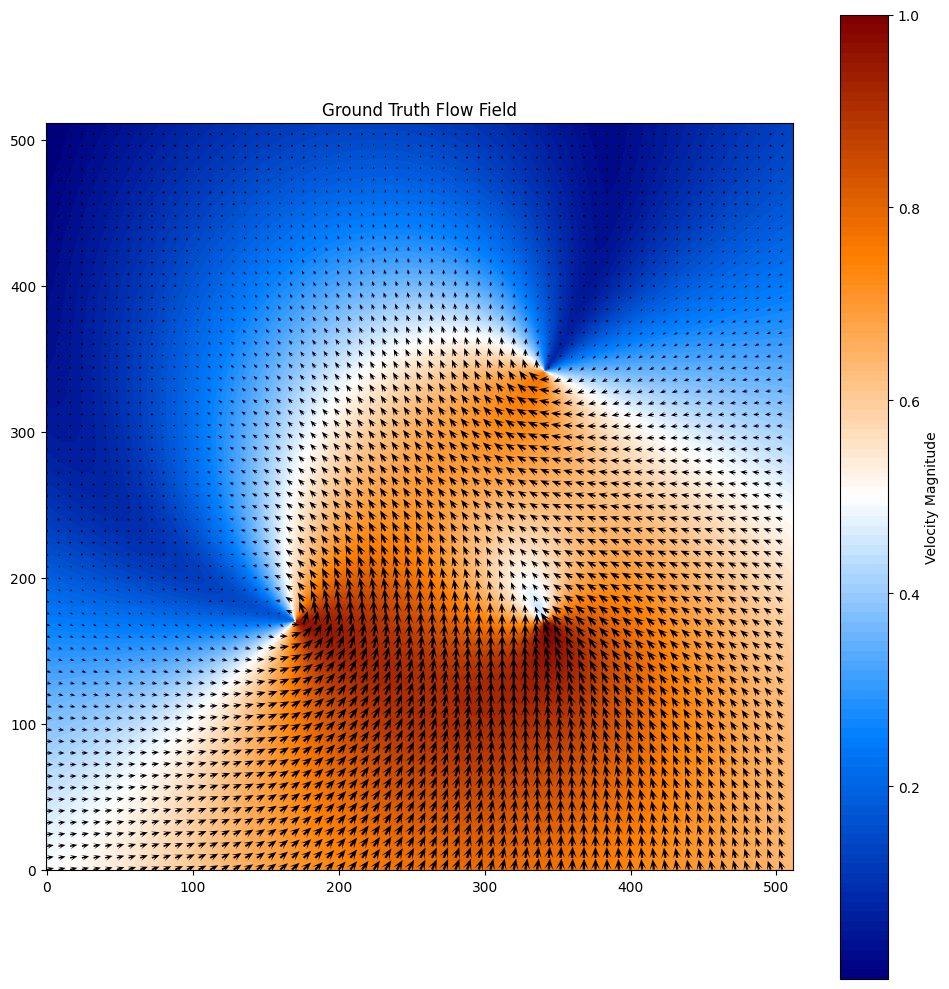

In [4]:
SIZE = 512
flow = generate_complex_flow(SIZE)
print(flow.shape)
plot_flow_field(flow, "Ground Truth Flow Field", SIZE // 8)

In [5]:
class ODE(nn.Module):
	def __init__(self, input_dim, hidden_dims):
		super(ODE, self).__init__()
		dim_list = [input_dim] + list(hidden_dims) + [input_dim]
		layers = []
		for i in range(len(dim_list) - 1):
			layers.append(nn.Linear(dim_list[i], dim_list[i + 1]))
			if i < len(dim_list) - 2:
				layers.append(nn.ReLU())
		self.mlp = nn.Sequential(*layers)
	
	def forward(self, x):
		x = self.mlp(x)
		return x

In [6]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


In [7]:
flow_tensor = torch.FloatTensor(flow)
flow_tensor = flow_tensor.to(device)
print(flow_tensor.shape)

y_coords = torch.arange(SIZE).view(1, SIZE, 1).expand(SIZE, SIZE, 1)
x_coords = torch.arange(SIZE).view(SIZE, 1, 1).expand(SIZE, SIZE, 1)
coordinate_tensor = torch.cat([x_coords, y_coords], dim=2)
coordinate_tensor = coordinate_tensor.float()
coordinate_tensor = coordinate_tensor.to(device)
print(coordinate_tensor.shape)

torch.Size([512, 512, 2])
torch.Size([512, 512, 2])


/usr/local/lib/python3.10/dist-packages/torch/cuda/__init__.py:716: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")


In [8]:
epochs = 10000
lr = 1e-3
weight_decay = 0
gamma = 0.999

ode = ODE(2, (256 for _ in range(3))).to(device)

optim = torch.optim.Adam(ode.parameters(), lr=lr, weight_decay=weight_decay)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optim, gamma=gamma)

for epoch in range(epochs):
    estimated_flow_tensor = ode(coordinate_tensor)

    loss = F.mse_loss(flow_tensor, estimated_flow_tensor)
    print(f'Epoch {epoch+1}, Loss: {loss}')

    optim.zero_grad()
    loss.backward()
    optim.step()
    scheduler.step()

Epoch 1, Loss: 139.27603149414062
Epoch 2, Loss: 437.1593017578125
Epoch 3, Loss: 82.47259521484375
Epoch 4, Loss: 21.911380767822266
Epoch 5, Loss: 96.9756851196289
Epoch 6, Loss: 76.74192810058594
Epoch 7, Loss: 25.447086334228516
Epoch 8, Loss: 2.8590526580810547
Epoch 9, Loss: 8.948165893554688
Epoch 10, Loss: 20.554948806762695
Epoch 11, Loss: 22.190494537353516
Epoch 12, Loss: 14.275217056274414
Epoch 13, Loss: 4.9420342445373535
Epoch 14, Loss: 1.2314810752868652
Epoch 15, Loss: 4.022121906280518
Epoch 16, Loss: 7.965268611907959
Epoch 17, Loss: 8.513727188110352
Epoch 18, Loss: 5.729011535644531
Epoch 19, Loss: 2.267712354660034
Epoch 20, Loss: 0.5414950847625732
Epoch 21, Loss: 0.912324070930481
Epoch 22, Loss: 2.216057777404785
Epoch 23, Loss: 3.2401156425476074
Epoch 24, Loss: 3.3529720306396484
Epoch 25, Loss: 2.528402328491211
Epoch 26, Loss: 1.2829978466033936
Epoch 27, Loss: 0.3679499626159668
Epoch 28, Loss: 0.2176506519317627
Epoch 29, Loss: 0.6520723104476929
Epoch 30

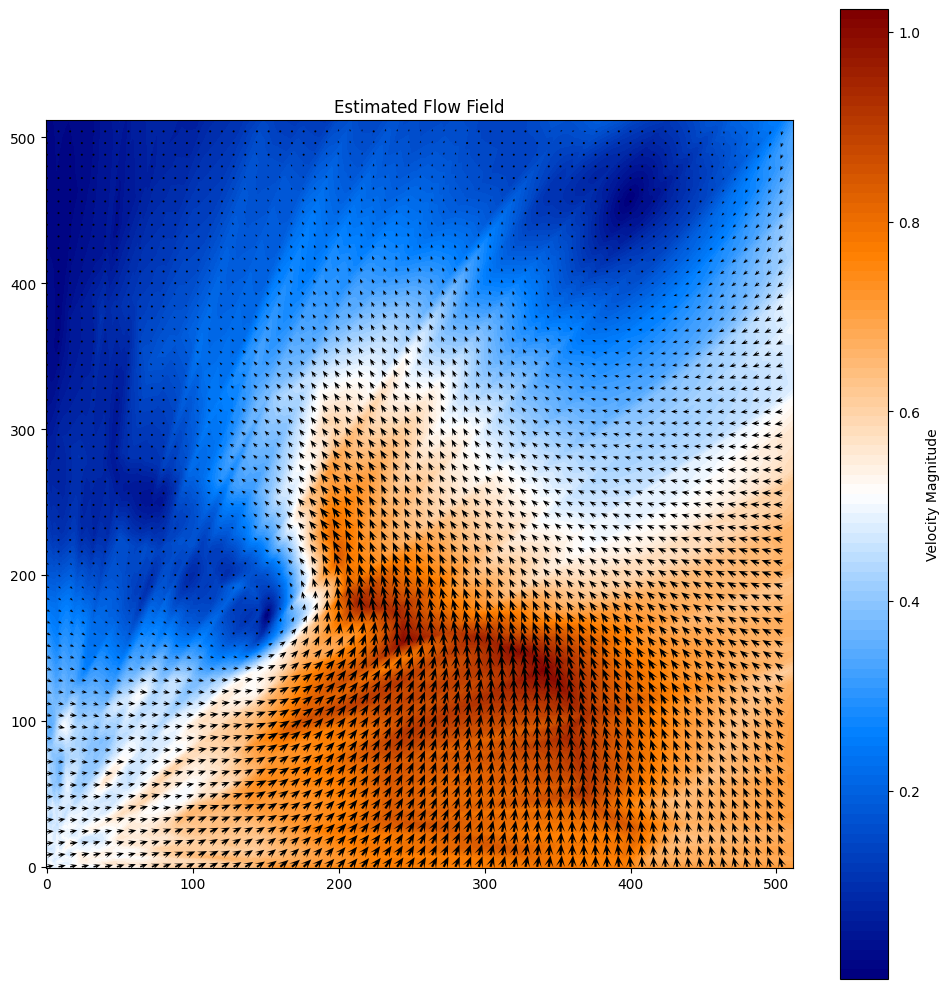

In [9]:
estimated_flow = estimated_flow_tensor.detach().cpu().numpy()
plot_flow_field(estimated_flow, "Estimated Flow Field", SIZE // 8)

In [ ]:
import torch
import torch.nn as nn
import numpy as np

class FourierFeatureODE(nn.Module):
    def __init__(self, input_dim, hidden_dims, fourier_scale=10.0, num_fourier_features=10, random_features=False):
        super(FourierFeatureODE, self).__init__()
        
        self.input_dim = input_dim
        self.num_fourier_features = num_fourier_features
        
        self.random_features = random_features
        self.register_buffer('B', torch.randn(input_dim, num_fourier_features) * fourier_scale)
        
        fourier_expanded_dim = input_dim + 2 * num_fourier_features
        dim_list = [fourier_expanded_dim] + list(hidden_dims) + [input_dim]
        layers = []
        for i in range(len(dim_list) - 1):
            layers.append(nn.Linear(dim_list[i], dim_list[i + 1]))
            if i < len(dim_list) - 2:
                layers.append(nn.ReLU())
        self.mlp = nn.Sequential(*layers)
    
    # Fourier Features Let Networks Learn High Frequency Functions in Low Dimensional Domains style?
    def compute_random_fourier_features(self, x):
        x_proj = torch.matmul(x, self.B)
        sin_features = torch.sin(2 * np.pi * x_proj)
        cos_features = torch.cos(2 * np.pi * x_proj)
        fourier_features = torch.cat([x, sin_features, cos_features], dim=-1)
        return fourier_features
    
    # NeRF/Transformer style
    def compute_positional_fourier_features(self, x):
        encodings = [x]
        for i in range(self.num_fourier_features // 2):
            freq = 2.0 ** i
            sin_features = torch.sin(freq * x)
            cos_features = torch.cos(freq * x)
            encodings.append(sin_features)
            encodings.append(cos_features)
        return torch.cat(encodings, dim=-1)

    def forward(self, x):
        x_fourier = self.compute_random_fourier_features(x) if self.random_features else self.compute_positional_fourier_features(x)
        output = self.mlp(x_fourier)
        return output

In [ ]:
lr = 1e-3
weight_decay = 0
gamma = 0.999

ode = FourierFeatureODE(2, (256 for _ in range(3)), num_fourier_features=126).to(device)

optim = torch.optim.Adam(ode.parameters(), lr=lr, weight_decay=weight_decay)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optim, gamma=gamma)

for epoch in range(epochs):
    estimated_flow_tensor_ff = ode(coordinate_tensor)

    loss = F.mse_loss(flow_tensor, estimated_flow_tensor_ff)
    print(f'Epoch {epoch+1}, Loss: {loss}')

    optim.zero_grad()
    loss.backward()
    optim.step()
    scheduler.step()

Epoch 1, Loss: 1.708089828491211
Epoch 2, Loss: 4.769547462463379
Epoch 3, Loss: 1.0789966583251953
Epoch 4, Loss: 0.2188502848148346
Epoch 5, Loss: 0.8983887434005737
Epoch 6, Loss: 0.9372379779815674
Epoch 7, Loss: 0.4550192058086395
Epoch 8, Loss: 0.11821798980236053
Epoch 9, Loss: 0.18854156136512756
Epoch 10, Loss: 0.3633807897567749
Epoch 11, Loss: 0.3666270971298218
Epoch 12, Loss: 0.24130894243717194
Epoch 13, Loss: 0.12027500569820404
Epoch 14, Loss: 0.07502861320972443
Epoch 15, Loss: 0.09660324454307556
Epoch 16, Loss: 0.1332116425037384
Epoch 17, Loss: 0.1466917246580124
Epoch 18, Loss: 0.1343456208705902
Epoch 19, Loss: 0.10820960998535156
Epoch 20, Loss: 0.08352787792682648
Epoch 21, Loss: 0.07470308244228363
Epoch 22, Loss: 0.08141325414180756
Epoch 23, Loss: 0.08829852938652039
Epoch 24, Loss: 0.09022960066795349
Epoch 25, Loss: 0.08641711622476578
Epoch 26, Loss: 0.07854858040809631
Epoch 27, Loss: 0.07240428775548935
Epoch 28, Loss: 0.07019820809364319
Epoch 29, Loss:

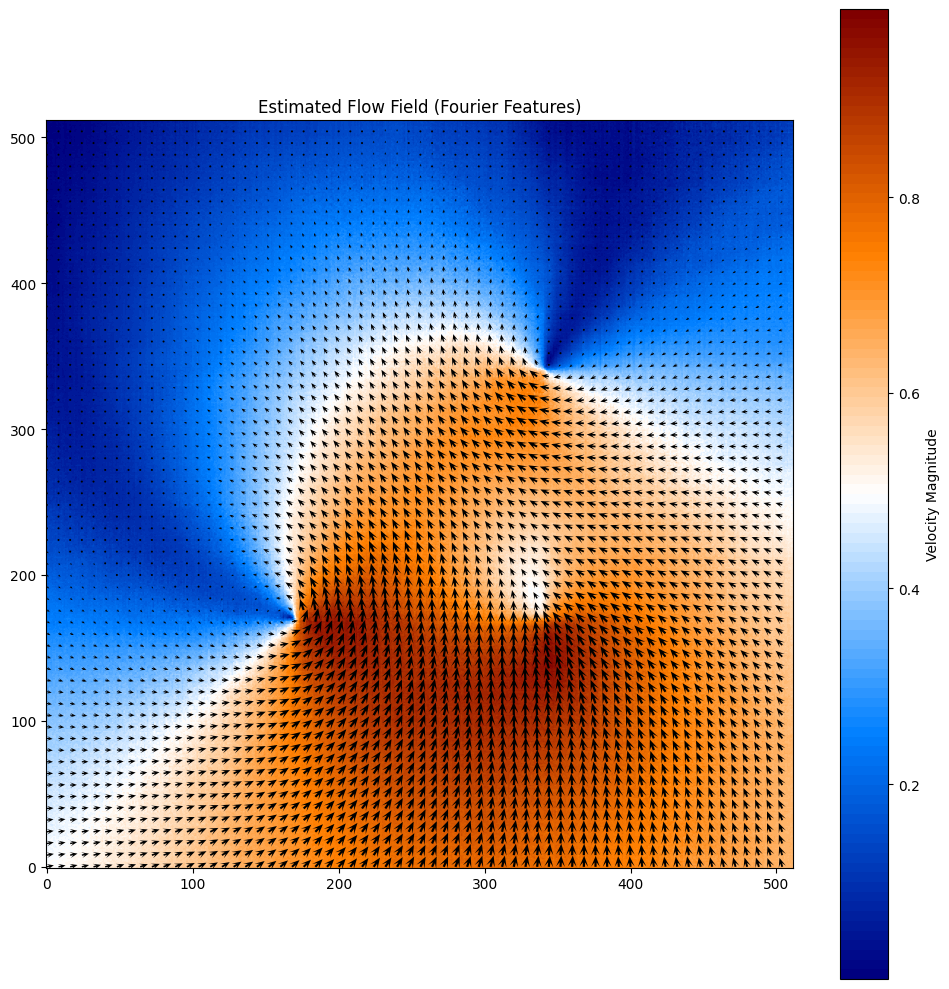

In [ ]:
estimated_flow_ff = estimated_flow_tensor_ff.detach().cpu().numpy()
plot_flow_field(estimated_flow_ff, "Estimated Flow Field (Fourier Features)", SIZE // 8)

In [15]:
lr = 1e-3
weight_decay = 0
gamma = 0.999

ode = FourierFeatureODE(2, (256 for _ in range(3)), num_fourier_features=126, random_features=True).to(device)

optim = torch.optim.Adam(ode.parameters(), lr=lr, weight_decay=weight_decay)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optim, gamma=gamma)

for epoch in range(epochs):
    estimated_flow_tensor_rff = ode(coordinate_tensor)

    loss = F.mse_loss(flow_tensor, estimated_flow_tensor_rff)
    print(f'Epoch {epoch+1}, Loss: {loss}')

    optim.zero_grad()
    loss.backward()
    optim.step()
    scheduler.step()

Epoch 1, Loss: 1.1612160205841064
Epoch 2, Loss: 7.748569488525391
Epoch 3, Loss: 1.0548162460327148
Epoch 4, Loss: 0.466827392578125
Epoch 5, Loss: 1.4468141794204712
Epoch 6, Loss: 1.2784481048583984
Epoch 7, Loss: 0.5457683205604553
Epoch 8, Loss: 0.15320828557014465
Epoch 9, Loss: 0.3400821089744568
Epoch 10, Loss: 0.44871675968170166
Epoch 11, Loss: 0.34858742356300354
Epoch 12, Loss: 0.2024860382080078
Epoch 13, Loss: 0.10684476792812347
Epoch 14, Loss: 0.08675089478492737
Epoch 15, Loss: 0.12277926504611969
Epoch 16, Loss: 0.15242484211921692
Epoch 17, Loss: 0.15125524997711182
Epoch 18, Loss: 0.13090883195400238
Epoch 19, Loss: 0.10610324889421463
Epoch 20, Loss: 0.08854980766773224
Epoch 21, Loss: 0.09262463450431824
Epoch 22, Loss: 0.09852927178144455
Epoch 23, Loss: 0.09594380855560303
Epoch 24, Loss: 0.09071335196495056
Epoch 25, Loss: 0.0857543796300888
Epoch 26, Loss: 0.08269871771335602
Epoch 27, Loss: 0.0814601480960846
Epoch 28, Loss: 0.08067643642425537
Epoch 29, Loss

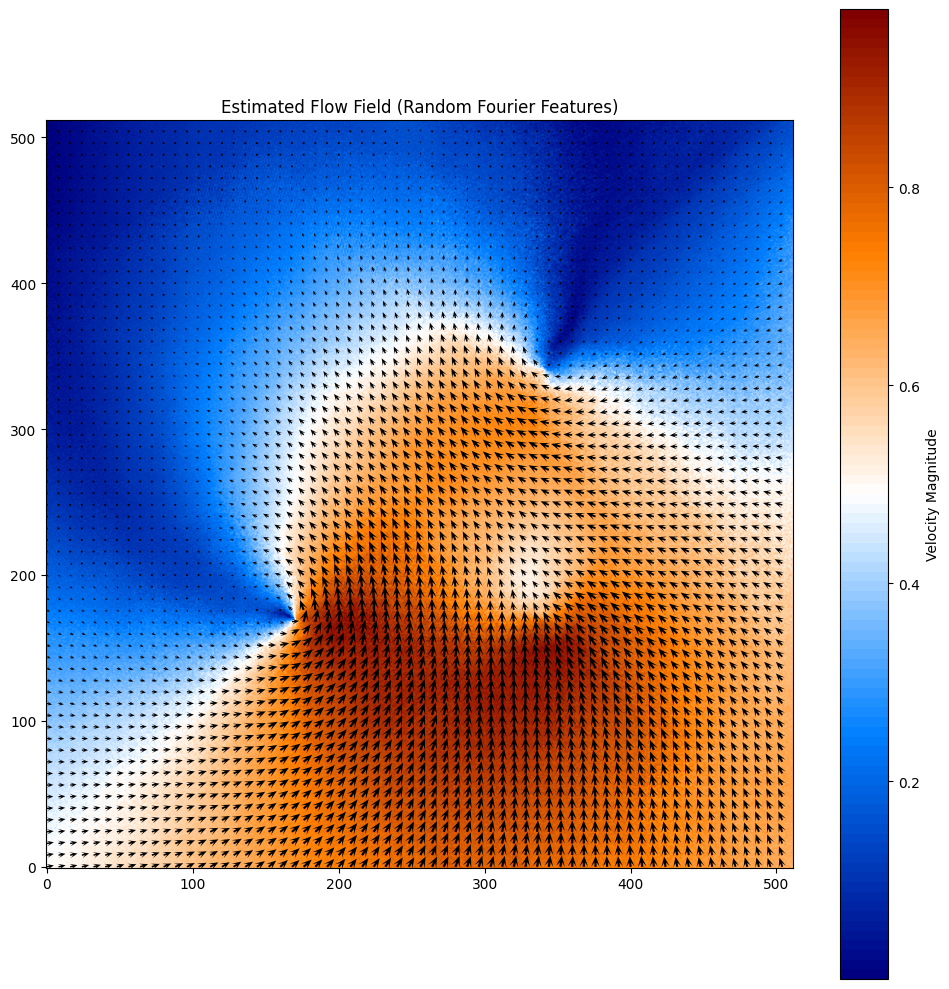

In [16]:
estimated_flow_rff = estimated_flow_tensor_rff.detach().cpu().numpy()
plot_flow_field(estimated_flow_rff, "Estimated Flow Field (Random Fourier Features)", SIZE // 8)